# What-if scenarios

In this stage of the analysis, we want to find how changes to the parameters of our model affect the simulated data.

Some areas of interest are:

- How would server utilisation (i.e. resource consumption) be affected by an increase in overall patient arrivals?
- How is the system affected by certain types of patients (e.g. short-stay, low-impact) arriving less frequently?
- What are the sensitivities of mean system times and server utilisation based on a change in $c$?

In [1]:
import glob
import itertools as it
import time

from ciw.dists import Exponential
from dask.diagnostics import ProgressBar
from scipy import stats

import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")

In [2]:
copd = pd.read_csv(
    "../data/clusters/copd_clustered.csv", parse_dates=["admission_date", "discharge_date"]
).dropna(subset=["cluster"])

copd["cluster"] = copd["cluster"].astype(int)

In [4]:
def get_times(diff):

    times = diff.dt.total_seconds().div(24 * 60 * 60, fill_value=0)
    return times

    
def get_queue_params(data, prop=1, lambda_coeff=1, dist=stats.expon):
    """ Get the arrival and service parameters from `data` and the given `prop`. """

    inter_arrivals = (
        data.set_index("admission_date").sort_index().index.to_series().diff()
    )
    interarrival_times = get_times(inter_arrivals)
    lambda_ = lambda_coeff / np.mean(interarrival_times)

    mean_system_time = np.mean(data["true_los"])
    mu_estimate = mean_system_time * prop

    queue_params = {"arrival": lambda_, "service": 1 / mu_estimate}

    return queue_params


@dask.delayed
def simulate_queue(data, column, props, num_servers, seed, max_time, lambda_coeff=1):

    ciw.seed(seed)
    all_queue_params = {}
    for (label, subdata), service_prop in zip(
        data.groupby(column), props
    ):
        all_queue_params[label] = get_queue_params(subdata, service_prop, lambda_coeff)

    N = ciw.create_network(
        arrival_distributions={
            f"Class {label}": [Exponential(params["arrival"])]
            for label, params in all_queue_params.items()
        },
        service_distributions={
            f"Class {label}": [Exponential(params["service"])]
            for label, params in all_queue_params.items()
        },
        number_of_servers=[num_servers],
    )

    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(max_time)

    return Q


def get_mean_server_utilisation(Q):

    return Q.transitive_nodes[0].server_utilisation


def get_simulation_results(Q, max_time):

    records = Q.get_all_records()
    results = pd.DataFrame(
        [r for r in records if max_time * 0.25 < r.arrival_date < max_time * 0.75]
    )

    results["utilisation"] = Q.transitive_nodes[0].server_utilisation
    results["system_time"] = results["exit_date"] - results["arrival_date"]
    return results[["utilisation", "system_time", "waiting_time", "queue_size_at_arrival", "customer_class"]]

In [5]:
with open("../data/wasserstein/best/params.txt", "r") as f:
    strings = f.read().split(" ")
    props, num_servers = list(map(float, strings[:-2])), int(strings[-2])

props, num_servers

([0.95, 1.0, 1.0, 0.5], 40)

In [5]:
seeds = 50
max_time = 365 * 4

tasks = (
    simulate_queue(copd, "cluster", props, num_servers, seed, max_time)
    for seed in range(seeds)
)

with ProgressBar():
    original_queues = dask.compute(*tasks, scheduler="processes", num_workers=8)

original_results = [get_simulation_results(Q, max_time) for Q in original_queues]

original_utilisation = np.mean([result["utilisation"].iloc[0] for result in original_results])
original_mean_time = np.mean([result["system_time"].mean() for result in original_results])

[########################################] | 100% Completed | 32.6s


## Change in overall patient arrivals

In [6]:
lambda_scaling_results = pd.concat(
    (pd.read_csv(filename) for filename in glob.iglob("../data/lambda_scaling/*.csv"))
)

In [7]:
lambda_utilisations = lambda_scaling_results.groupby("lambda_coeff")["utilisation"]

lower_utilisation = lambda_utilisations.quantile(0.025) / original_utilisation
mean_utilisation = lambda_utilisations.mean() / original_utilisation
upper_utilisation = lambda_utilisations.quantile(0.975) / original_utilisation

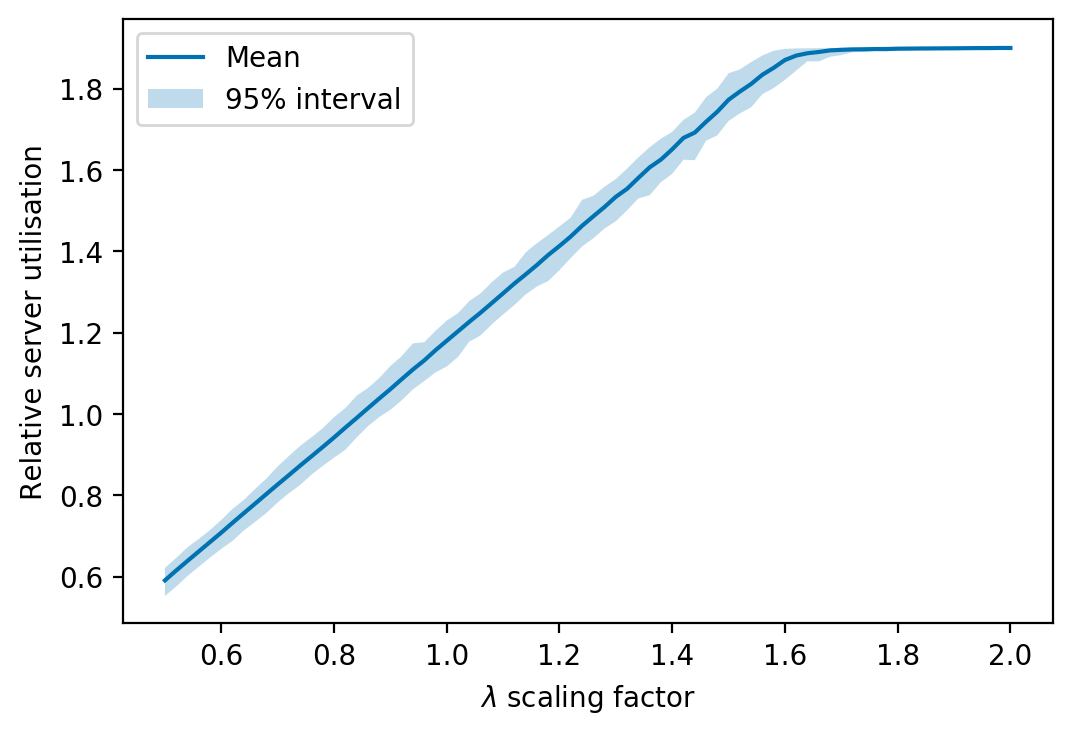

In [8]:
fig, ax = plt.subplots(dpi=200)

ax.plot(mean_utilisation, label="Mean")
ax.fill_between(
    lower_utilisation.index, lower_utilisation, upper_utilisation, alpha=0.25, label="95% interval"
)

ax.legend()
ax.set(
    xlabel="$\lambda$ scaling factor",
    ylabel="Relative server utilisation",
)

plt.savefig("../img/lambda_utilisation.pdf", transparent=True)

In [9]:
lambda_times = lambda_scaling_results.groupby("lambda_coeff")["system_time"]

lower_times = lambda_times.quantile(0.025) / original_mean_time
mean_times = lambda_times.mean() / original_mean_time
upper_times = lambda_times.quantile(0.975) / original_mean_time

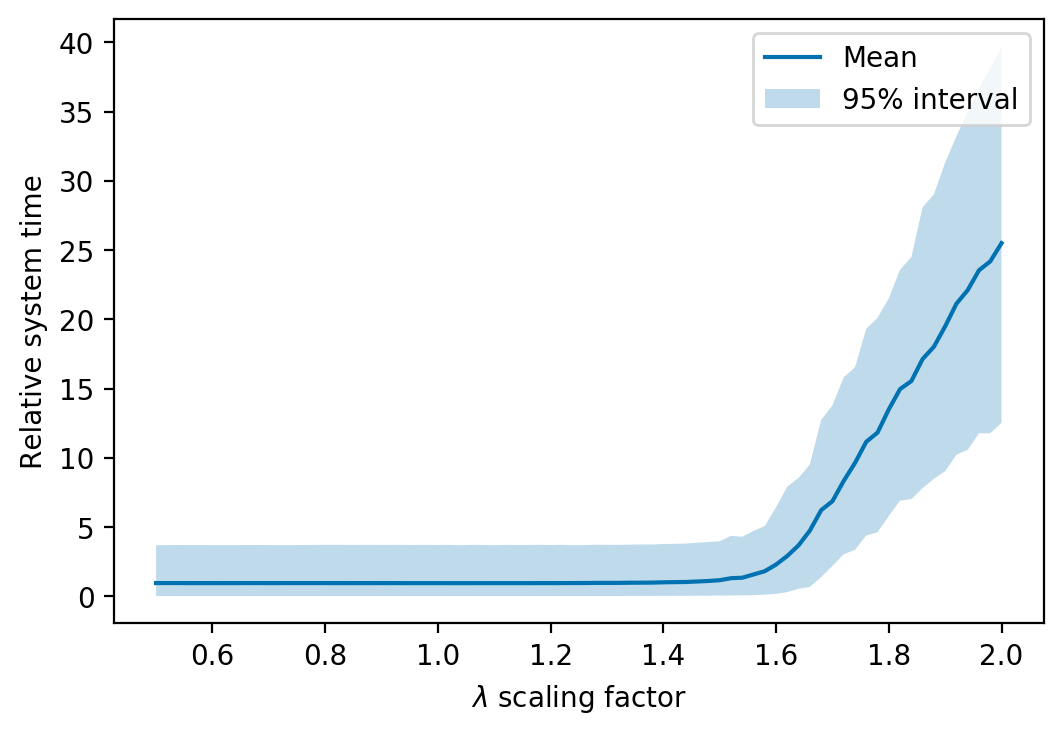

In [10]:
fig, ax = plt.subplots(dpi=200)

ax.plot(mean_times, label="Mean")
ax.fill_between(
    lower_times.index, lower_times, upper_times, alpha=0.25, label="95% interval"
)

ax.legend()
ax.set(
    xlabel="$\lambda$ scaling factor",
    ylabel="Relative system time",
#     yscale="log",
)

plt.savefig("../img/lambda_time.pdf", transparent=True)

## Sensitivity analysis for $c$

In [11]:
server_results = pd.concat(
    (pd.read_csv(filename) for filename in glob.iglob("../data/num_servers_change/*.csv"))
)

server_results["relative_num_servers"] = server_results["num_servers"] / num_servers

In [12]:
server_utilisations = server_results.groupby("relative_num_servers")["utilisation"]

lower_utilisation = server_utilisations.quantile(0.025) / original_utilisation
mean_utilisation = server_utilisations.mean() / original_utilisation
upper_utilisation = server_utilisations.quantile(0.975) / original_utilisation

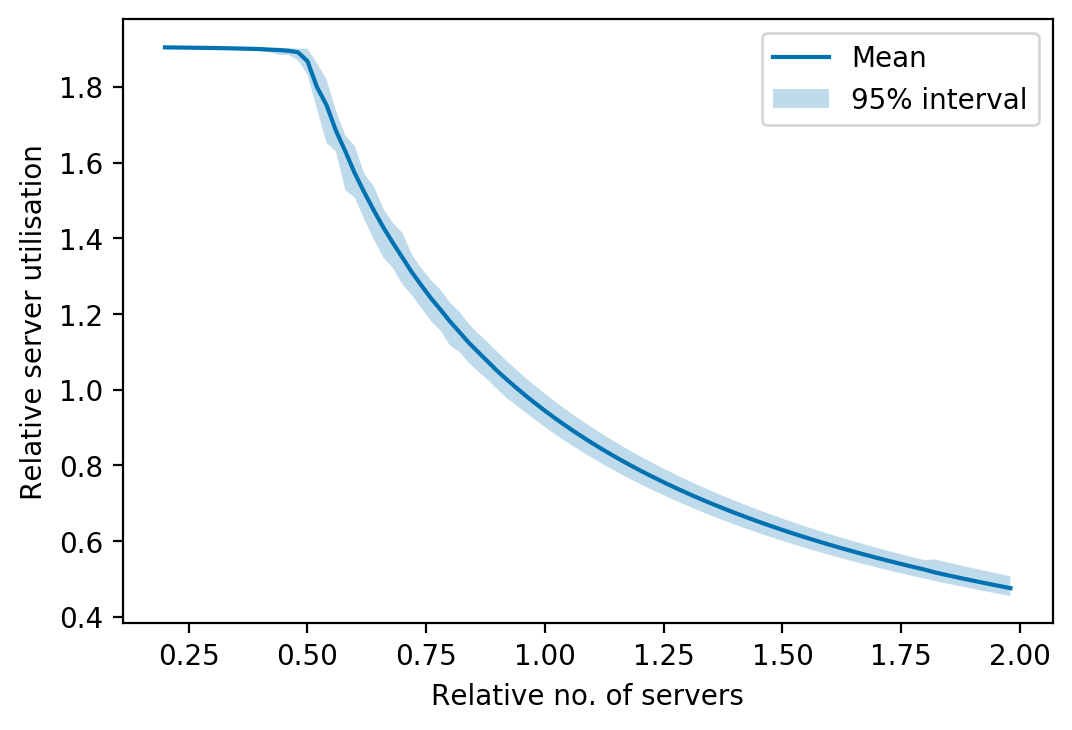

In [13]:
fig, ax = plt.subplots(dpi=200)

ax.plot(mean_utilisation, label="Mean")
ax.fill_between(
    lower_utilisation.index, lower_utilisation, upper_utilisation, alpha=0.25, label="95% interval"
)

ax.legend()
ax.set(
    xlabel="Relative no. of servers",
    ylabel="Relative server utilisation",
)

plt.savefig("../img/servers_utilisation.pdf", transparent=True)

In [25]:
server_times = server_results.groupby("relative_num_servers")["system_time"]

lower_times = server_times.quantile(0.025) / original_mean_time
mean_times = server_times.mean() / original_mean_time
upper_times = server_times.quantile(0.975) / original_mean_time

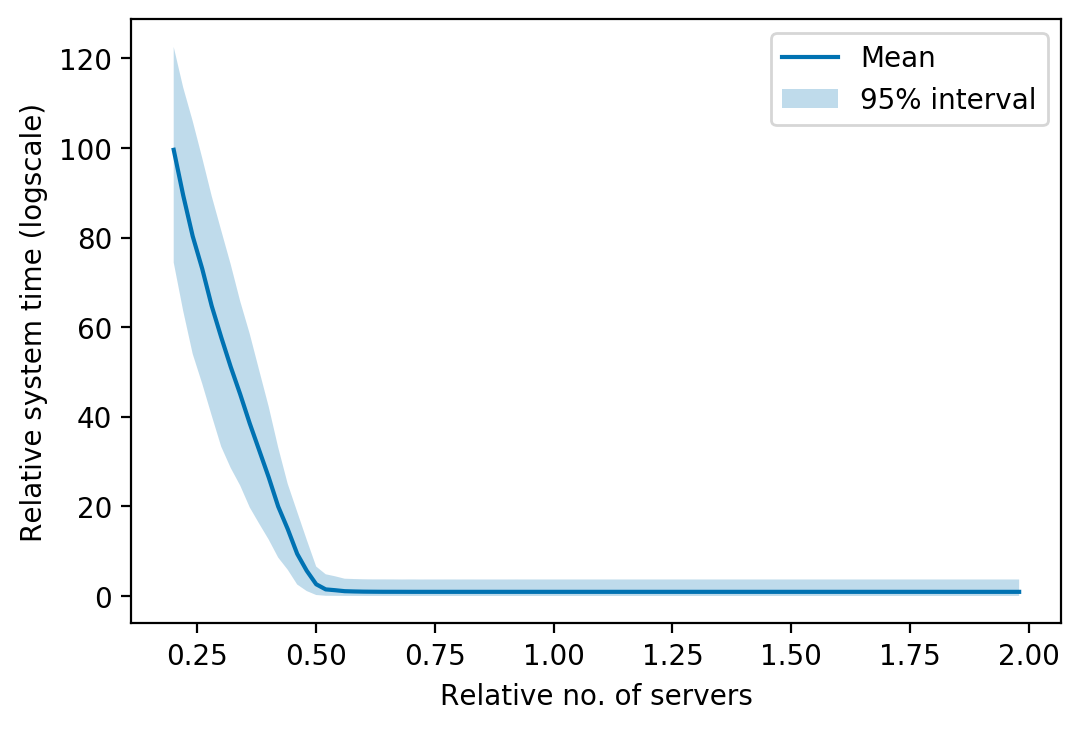

In [15]:
fig, ax = plt.subplots(dpi=200)

ax.plot(mean_times, label="Mean")
ax.fill_between(
    lower_times.index, lower_times, upper_times, alpha=0.25, label="95% interval"
)

ax.legend()
ax.set(
    xlabel="Relative no. of servers",
    ylabel="Relative system time (logscale)",
#     yscale="log",
)

plt.savefig("../img/servers_time.pdf", transparent=True)

## Transferring patients between clusters

In [16]:
prop_to_move_range = np.arange(0, 1, 0.05)
n_clusters = copd["cluster"].nunique()
label_combinations = [
    labels
    for labels in it.product(range(n_clusters), repeat=2)
    if labels[0] != labels[1]
]

all_moving_results = pd.concat(
    [pd.read_csv(filename) for filename in glob.iglob("../data/moving_clusters/*.csv")]
)

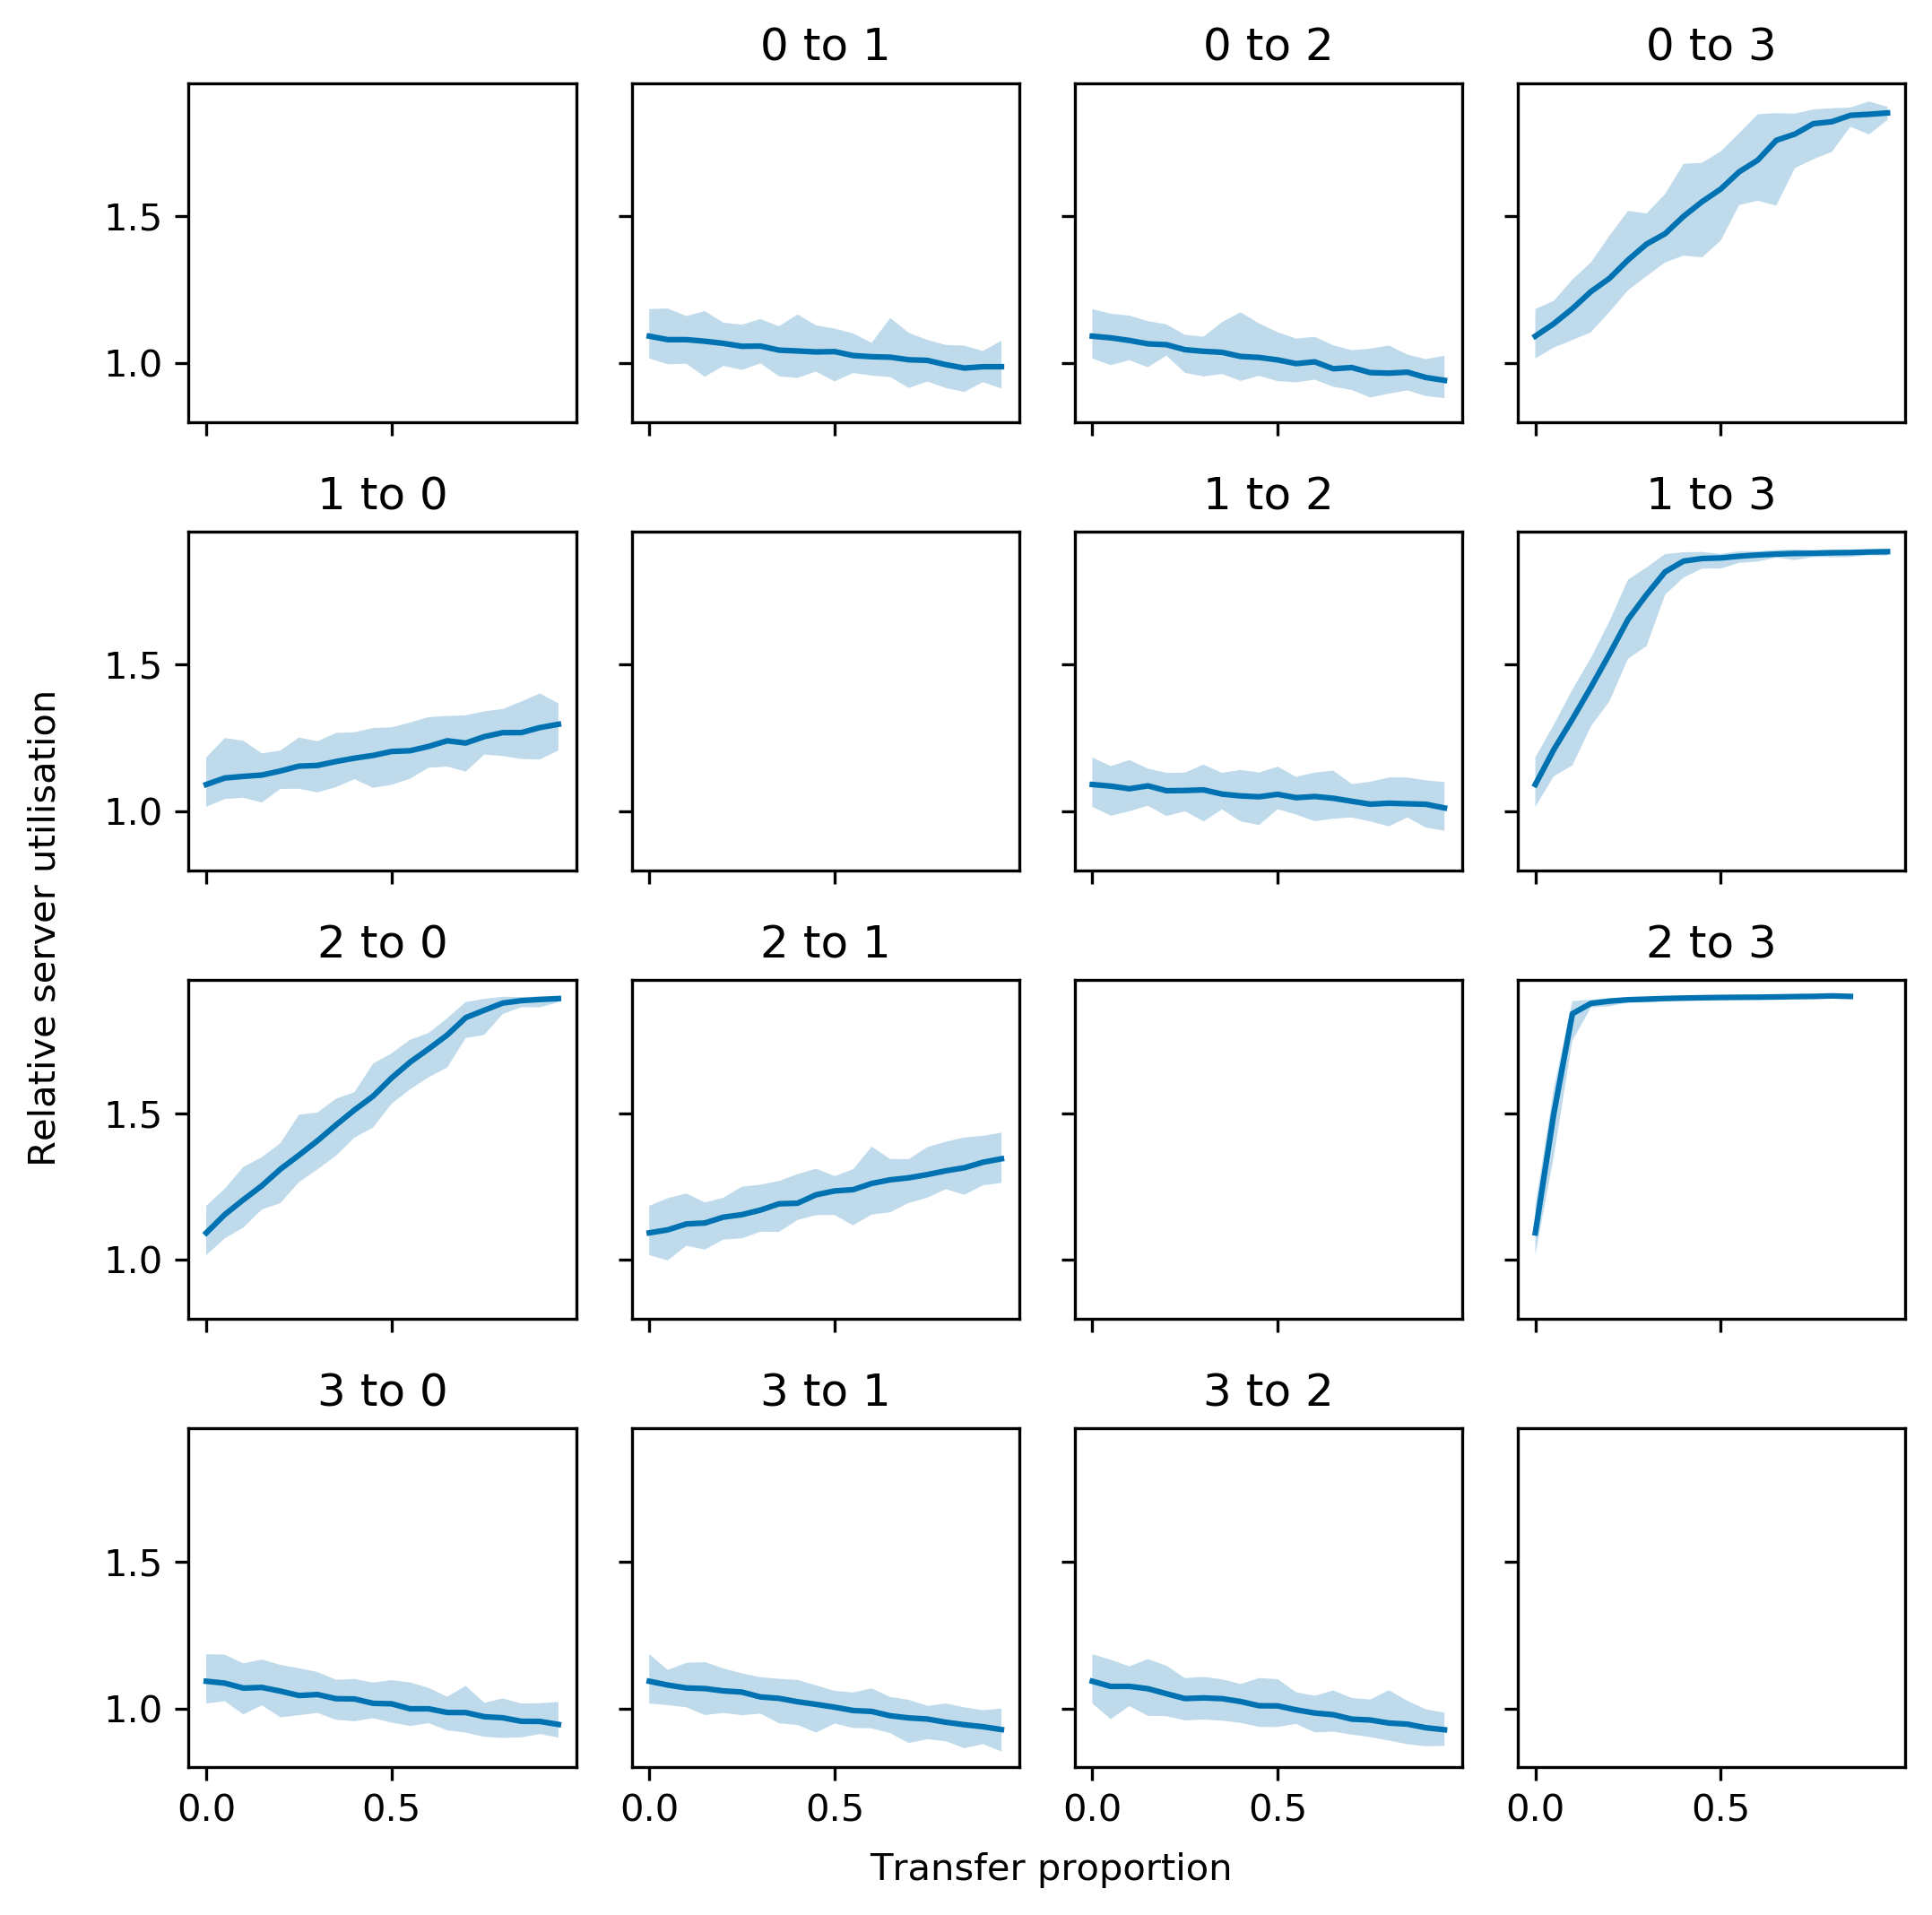

In [28]:
fig, axes = plt.subplots(nrows=n_clusters, ncols=n_clusters, sharex=True, sharey=True, figsize=(7, 7), dpi=300)

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

ylabel = fig.text(
    0, 0.5*(bottom+top), "Relative server utilisation", ha="right", va="center", rotation="vertical"
)

xlabel = fig.text(
    0.525*(left+right), -0.01, "Transfer proportion", ha="center", va="bottom", rotation="horizontal"
)

for origin, destination in it.product(range(n_clusters), repeat=2):

    ax = axes[origin, destination]

    if origin != destination:
        data = all_moving_results[
            (all_moving_results["origin"] == origin)
            & (all_moving_results["destination"] == destination)
        ]

        utilisations = data.groupby("prop_to_move")["utilisation"]

        lower_data = utilisations.quantile(0.025) / original_utilisation
        mean_data = utilisations.mean() / original_utilisation
        upper_data = utilisations.quantile(0.975) / original_utilisation

        ax.plot(mean_data)
        ax.fill_between(lower_data.index, lower_data, upper_data, alpha=0.25)
        ax.set_title(f"{origin} to {destination}")

plt.tight_layout()
plt.savefig(
    "../img/moving_utilisation.pdf",
    bbox_extra_artists=(xlabel, ylabel),
    bbox_inches="tight",
    transparent=True,
)

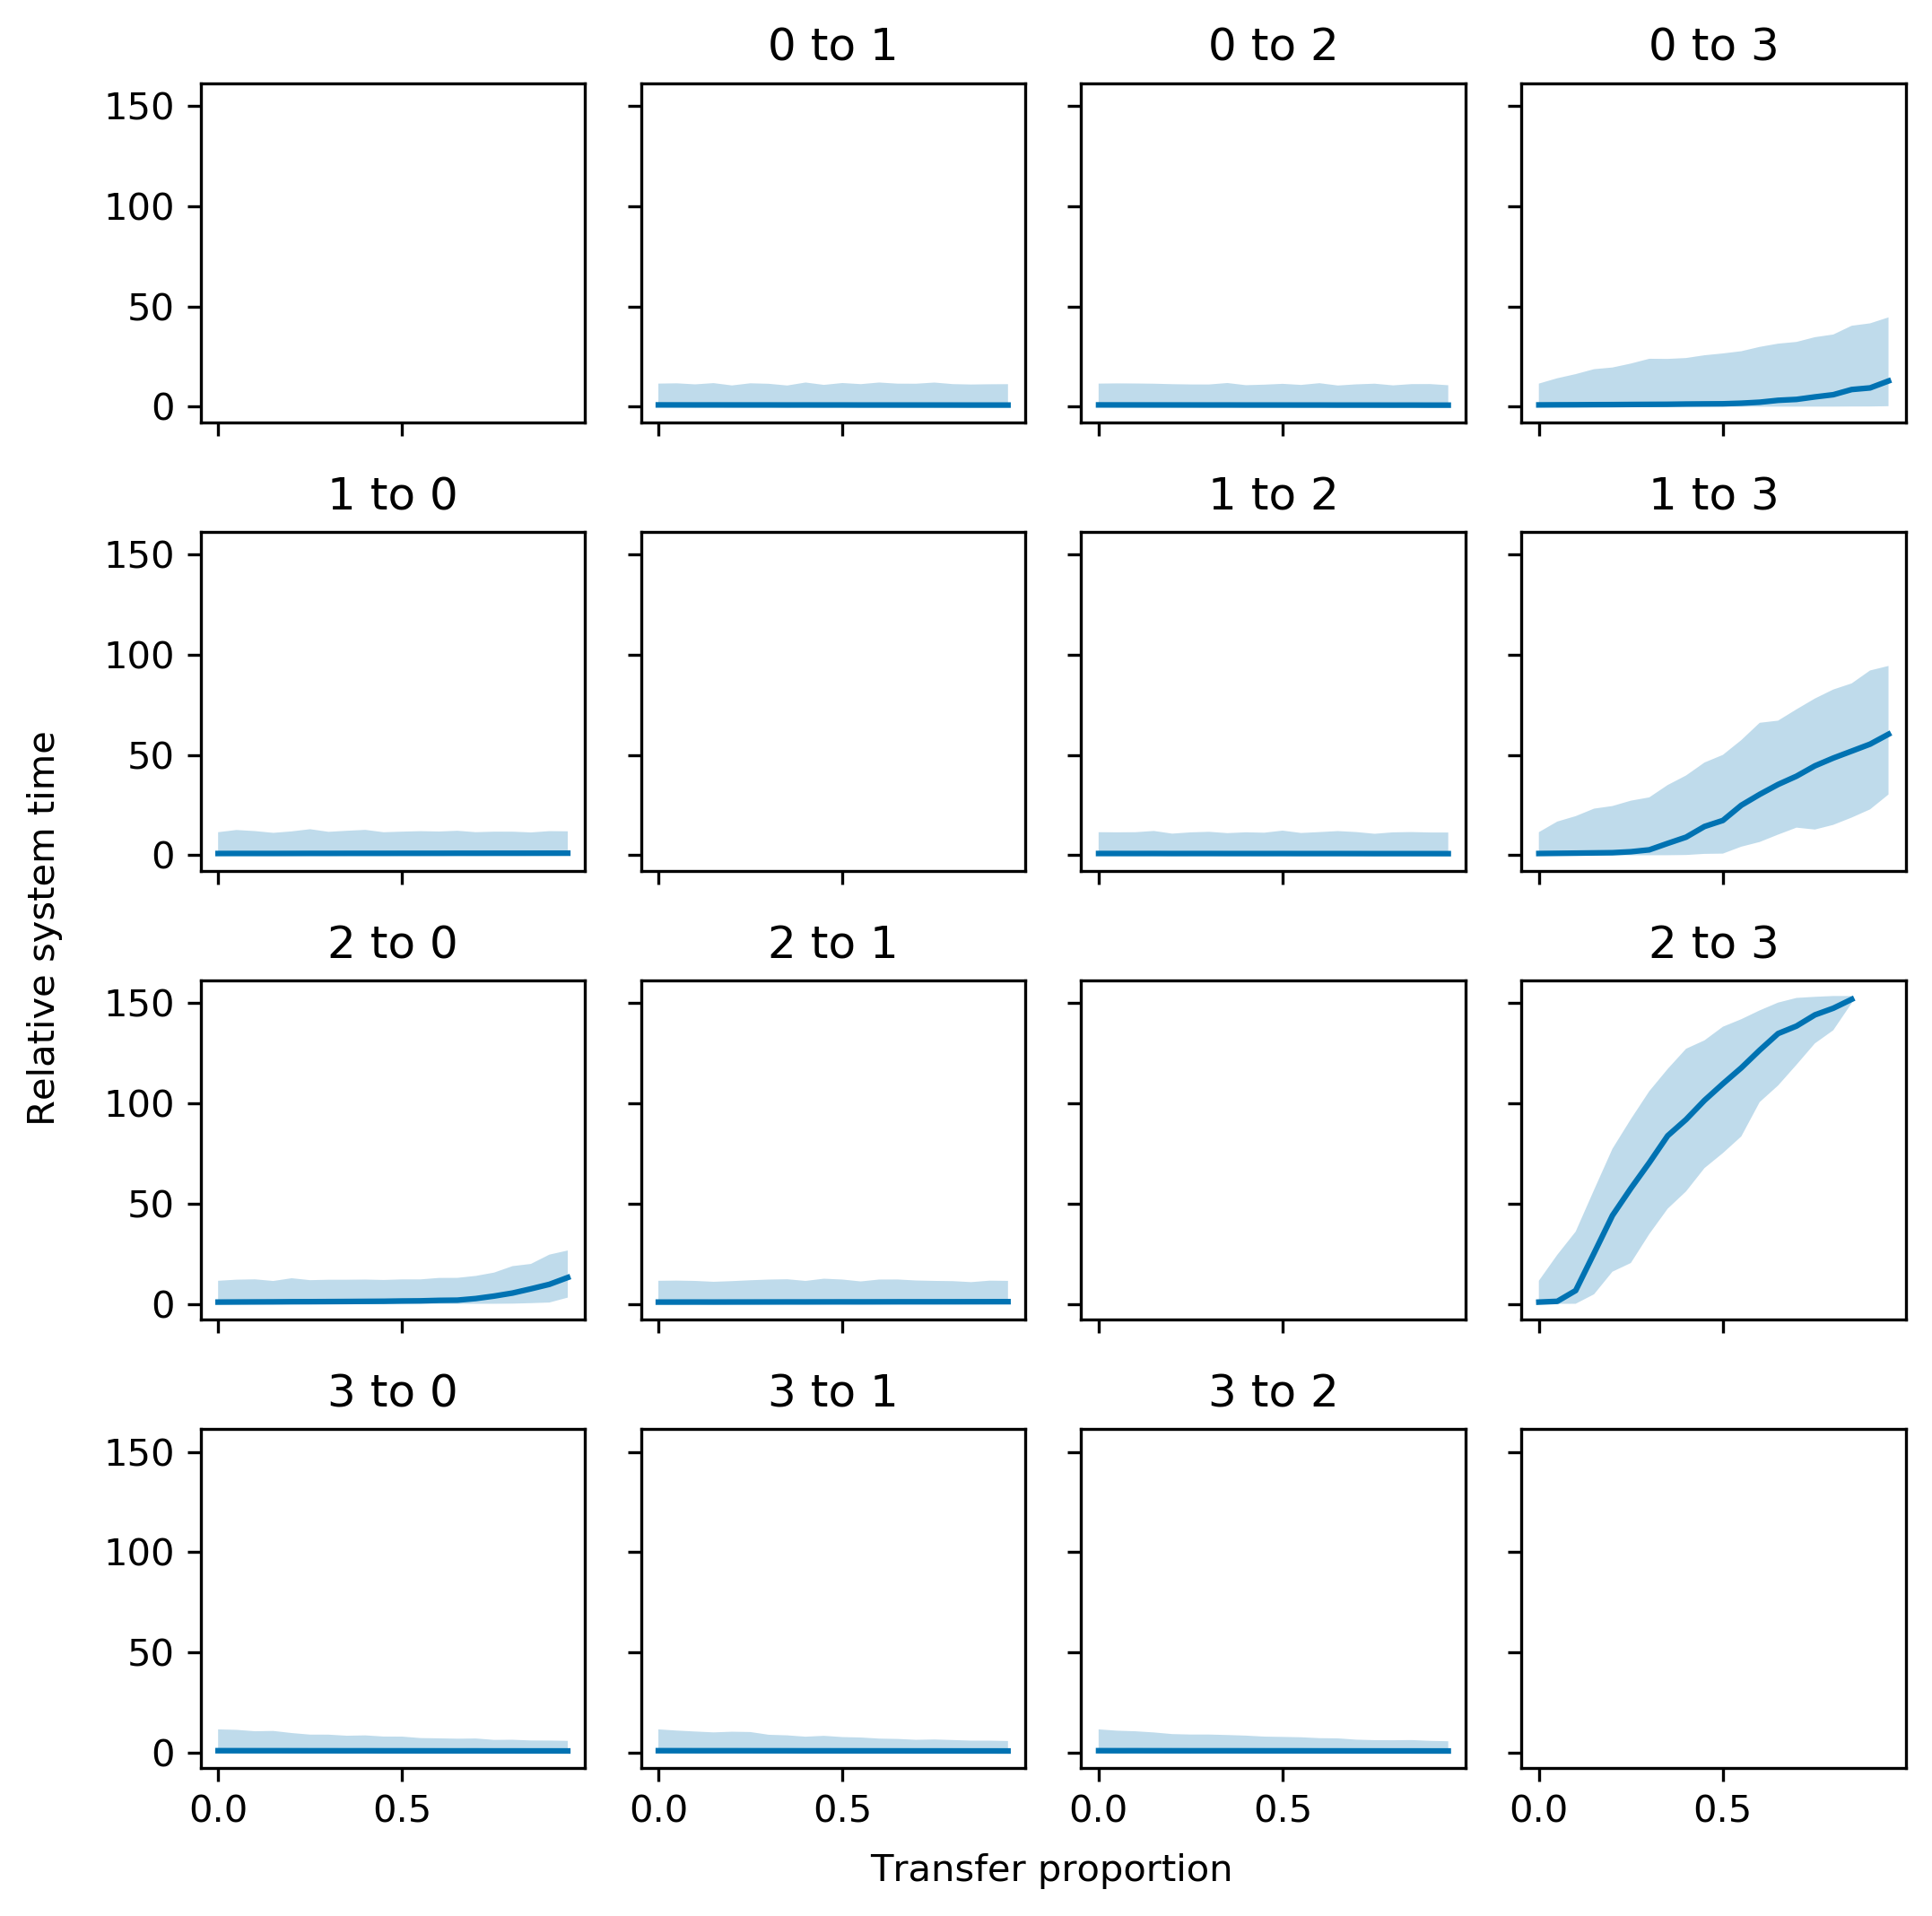

In [38]:
fig, axes = plt.subplots(nrows=n_clusters, ncols=n_clusters, sharex=True, sharey=True, figsize=(7, 7), dpi=300)

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

ylabel = fig.text(
    0, 0.5*(bottom+top), "Relative system time", ha="right", va="center", rotation="vertical"
)

xlabel = fig.text(
    0.525*(left+right), -0.01, "Transfer proportion", ha="center", va="bottom", rotation="horizontal"
)

for origin, destination in it.product(range(n_clusters), repeat=2):

    ax = axes[origin, destination]

    if origin != destination:
        data = all_moving_results[
            (all_moving_results["origin"] == origin)
            & (all_moving_results["destination"] == destination)
        ]

        system_times = data.groupby("prop_to_move")["system_time"]

        lower_data = system_times.quantile(0.005) / original_mean_time
        mean_data = system_times.mean() / original_mean_time
        upper_data = system_times.quantile(0.995) / original_mean_time

        ax.plot(mean_data)
        ax.fill_between(lower_data.index, lower_data, upper_data, alpha=0.25)
        ax.set_title(f"{origin} to {destination}")

plt.tight_layout()
plt.savefig(
    "../img/moving_time.pdf",
    bbox_extra_artists=(xlabel, ylabel),
    bbox_inches="tight",
    transparent=True,
)

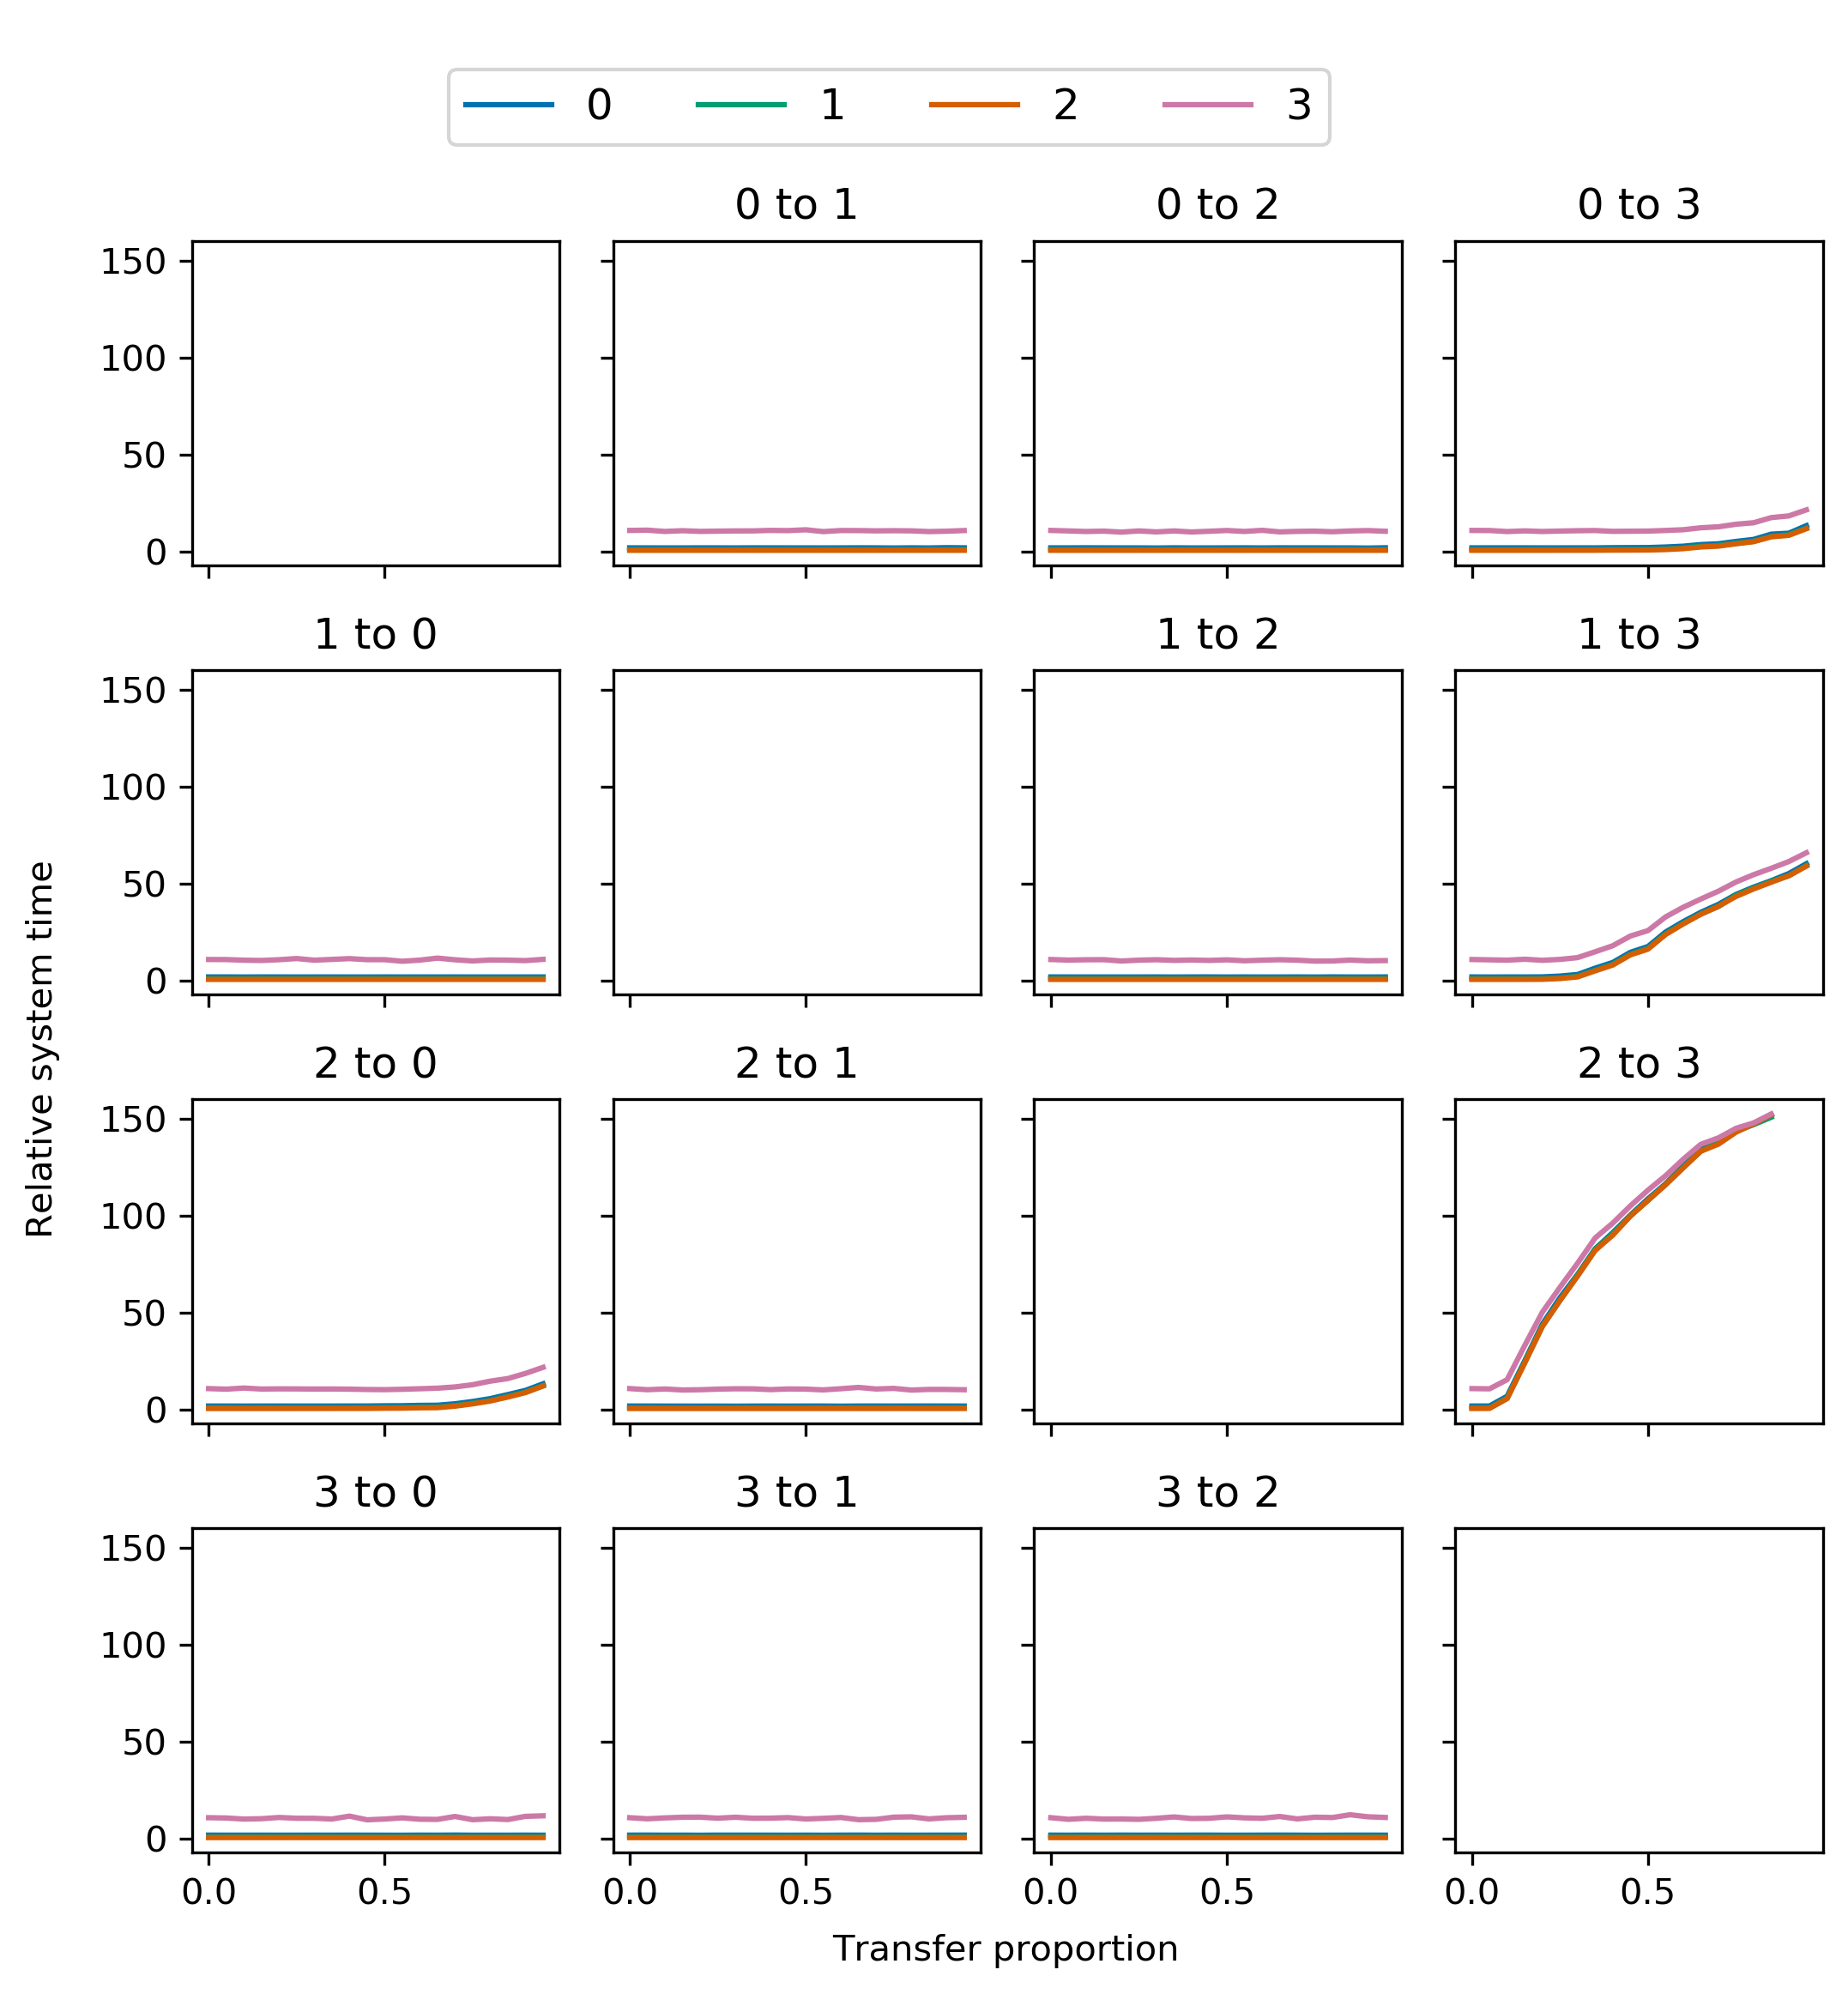

In [19]:
fig, axes = plt.subplots(nrows=n_clusters, ncols=n_clusters, sharex=True, sharey=True, figsize=(7, 7), dpi=300)

ylabel = fig.text(
    0, 0.5*(bottom+top), "Relative system time", ha="right", va="center", rotation="vertical"
)

xlabel = fig.text(
    0.525*(left+right), -0.01, "Transfer proportion", ha="center", va="bottom", rotation="horizontal"
)

for origin, destination in it.product(range(n_clusters), repeat=2):

    ax = axes[origin, destination]
#     ax.set_yscale("log")

    if origin != destination:
        data = all_moving_results[
            (all_moving_results["origin"] == origin)
            & (all_moving_results["destination"] == destination)
        ]

        lines, labels = [], []
        for label, subdata in data.groupby("customer_class"):
            subdata = subdata.groupby("prop_to_move")["system_time"].mean() / original_mean_time
            
            line = ax.plot(subdata)
            lines.append(line[0])
            labels.append(label)

        ax.set_title(f"{origin} to {destination}")

legend = plt.figlegend(
    lines, labels, ncol=n_clusters, bbox_to_anchor=(0.75, 1.08), prop={'size': 12}
)

plt.tight_layout()
plt.savefig(
    "../img/moving_time_split.pdf",
    bbox_extra_artists=(xlabel, ylabel, legend),
    bbox_inches="tight",
    transparent=True,
)